In [1]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from utils import read_yaml

LOAD_SPLIT_CONFIG_PATH = "../config/read_data.yaml"

def run_split_data(df, test_size):
    """
    split data into train and test.
    
    Args:
    - df: Dataframe we want to split.
    - TEST_SIZE(float): Size of the test and validation dataset size.
    
    Returns:
    - train
    - test
    """
    

    train, test = train_test_split(df,
                                    shuffle=False,
                                    test_size=test_size,
                                    random_state= 42)

    return train, test

def main_read(params):
    df = pd.read_csv(params['file_loc'])
    train, test = run_split_data(df, params['test_size'])

    joblib.dump(train, params["out_path"]+"train.pkl")
    joblib.dump(test, params["out_path"]+"test.pkl")

    return train, test

if __name__ == "__main__":
    params = read_yaml(LOAD_SPLIT_CONFIG_PATH)
    train, test = main_read(params)

In [43]:
import pandas as pd
import joblib
from utils import read_yaml

LOAD_SPLIT_CONFIG_PATH = "../config/read_data.yaml"

def load_split_data(params):
    """
    Loader from read data.
    
    Args:
    - params(dict): read data params.
    
    Returns:
    - train(DataFrame): inputs of train set.
    - test(DataFrame): inputs of test set.
    """

    train = joblib.load(params["out_path"]+"train.pkl")
    test = joblib.load(params["out_path"]+"test.pkl")

    return train, test

def create_datetime(df):
    """
    convert date columns to pandas datetime.

    Returns:
    date in dataframe into pandas datetime
    """

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['date'] = pd.to_datetime(df['date'])
    
    return df

def create_feature(df):
    """
    Create breakdown of timestamp into detail date and time


    Returns:
    Columns with year, month, day, hour, minutes.
    """

    df['year'] = df['timestamp'].apply(lambda x : x.year)
    df['month'] = df['timestamp'].apply(lambda x : x.month)
    df['day'] = df['timestamp'].apply(lambda x : x.day)
    df['hour'] = df['timestamp'].apply(lambda x : x.hour)
    df['minute'] = df['timestamp'].apply(lambda x : x.minute)
    return df

def main_preprocessing(train, test):
    train = create_datetime(train)
    train = create_feature(train)
    test = create_datetime(test)
    test = create_feature(test)

    joblib.dump(train, params["out_path"]+"train_preprocessed.pkl")
    joblib.dump(test, params["out_path"]+"test_preprocessed.pkl")

    return train, test

if __name__ == "__main__":
    params_feature = read_yaml(LOAD_SPLIT_CONFIG_PATH)
    train, test = load_split_data(params_feature)
    train_preprocessed, test_preprocessed = main_preprocessing(train, test)

In [44]:
# k-means clustering
from numpy import unique
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from matplotlib import pyplot
# define dataset
import numpy as np

def create_cluster(df, n_cluster):
    """
    K-means clustering algorithm.
    
    Args:
    Dataframe and number of cluster.

    Returns:
    assigned cluster.
    """

    X = np.array(df.value).reshape(-1,1)
    model = KMeans(n_clusters=3)
    # fit the model
    model.fit(X)
    # assign a cluster to each example
    yhat = model.predict(X)
    df['cluster'] = yhat
    
    return df

def main_cluster(train, test, n_cluster):
    train_clustered = create_cluster(train, n_cluster)
    test_clustered = create_cluster(test, n_cluster)

    joblib.dump(train_clustered, params["out_path"]+"train_clustered.pkl")
    joblib.dump(test_clustered, params["out_path"]+"test_clustered.pkl")

    return train_clustered, test_clustered

if __name__ == "__main__":
    params_feature = read_yaml(LOAD_SPLIT_CONFIG_PATH)
    train_clustered, test_clustered = main_cluster(train_preprocessed, test_preprocessed, 3)

In [ ]:
from sklearn.ensemble import IsolationForest

def create_anomaly(train, test):
    """
    Isolation Forest Algorithm.

    Args:
    - Dataframe

    Returns:
    - Assigned anomaly detection
    - Anomaly score from the Isolation Forest Desicion Function
    - clf = parameters from training data to testing data
    """

    df_train = train.drop(['timestamp', 'date'], axis=1)
    df_test = test.drop(['timestamp', 'date'], axis=1)
    clf = IsolationForest(n_estimators=100,max_samples='auto',contamination=float(0.05),random_state=42).fit(df_train)
    
    #train
    score = clf.decision_function(df_train)
    train['anomaly'] = clf.predict(df_train)
    train['score'] = score

    #test
    score = clf.decision_function(df_test)
    test['anomaly'] = clf.predict(df_test)
    test['score'] = score

    joblib.dump(clf, params["out_path"]+"clf.pkl")
    joblib.dump(train, params["out_path"]+"train_anomaly.pkl")
    joblib.dump(test, params["out_path"]+"test_anomaly.pkl")
    
    return train, test

if __name__ == "__main__":
    params_feature = read_yaml(LOAD_SPLIT_CONFIG_PATH)
    train_anomaly, test_anomaly = create_anomaly(train_clustered, test_clustered)

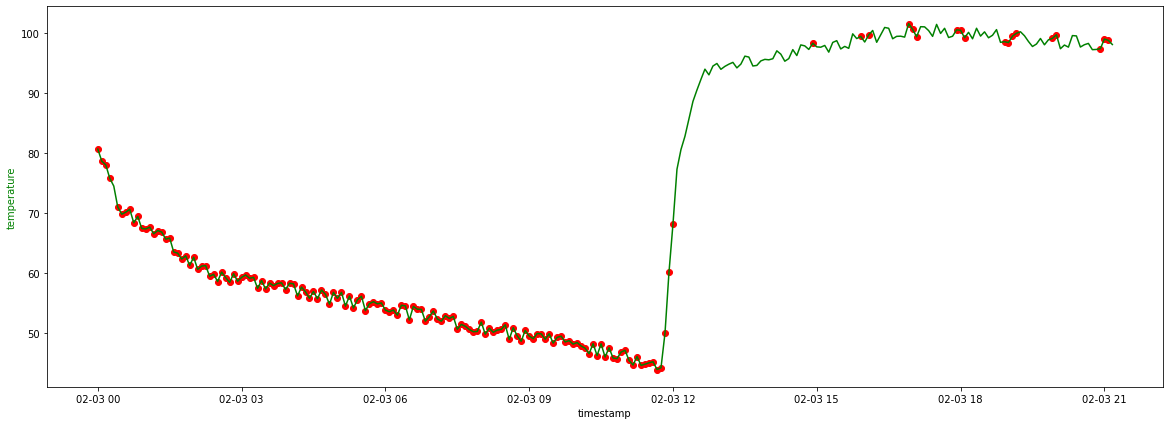

In [146]:
import matplotlib.pyplot as plt

def main_viz_date(date_ent, df):
    """
    this function is to visualize a specific date from the data. we could choose from data train or data test
    if the result just a plain figure that means theres no records with that date.

    args:
    - date_ent: entry the data with format YYYY-MM-DD, outside that will gives an error.
    - df: dataframe

    returns:
    a visualization figure of anomaly data points within that a date we choose.
    """
    df_date = df.loc[(df['date'] == date_ent)]

    plt.rcParams["figure.figsize"] = (20,7)
    fig, ax1 = plt.subplots()

    ax1.plot(df_date['timestamp'],df_date['value'], 'g-')

    a = df_date.loc[df_date['anomaly'] == -1, ['timestamp','value']] #anomaly
    ax1.scatter(a.timestamp,a['value'], color='red', label = 'Anomaly')

    ax1.set_xlabel('timestamp')
    ax1.set_ylabel('temperature', color='g')

    plt.show()

if __name__ == "__main__":
    date_ent = input("Please input with format YYYY-MM-DD")

main_viz_date(date_ent, train_anomaly)